## About the Project
This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as neural style transfer and the technique is outlined in A Neural Algorithm of Artistic Style (Gatys et al.).

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to cyclegan). This approach is much faster (up to 1000x).

For a simple application of style transfer check out this tutorial to learn more about how to use the pretrained Arbitrary Image Stylization model from TensorFlow Hub or how to use a style transfer model with TensorFlow Lite. This project is based on the Neural style transfer using Tensorflow.

## What is Neural Style Transfer?
Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

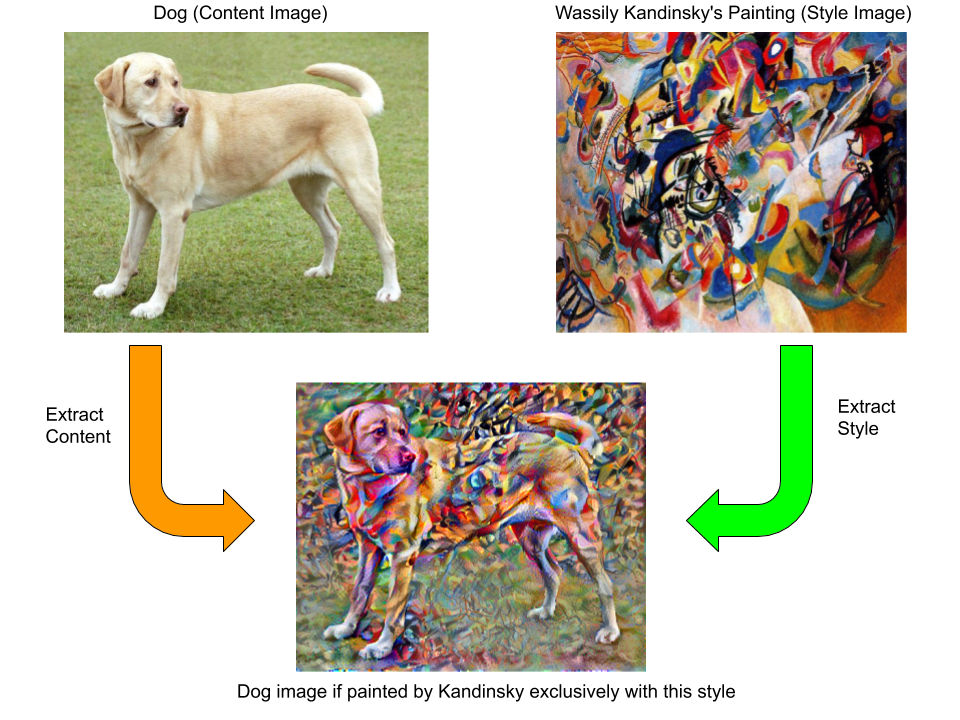

## How is Neural Style Transfer different?
In general, we will have a lot of data and we train the weights by minimizing the loss function.

Unlike other deep learning methods, here we use pre-trained weights which were trained on millions of images and update the pixel values to get the stylized image.

Thus, neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

How do we do this?
**What does a CNN do?**

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image.

This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures.

As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes.

Since the CNNs try to understand the images, they are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances.

Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor.

**What are we going to do?**

By accessing intermediate layers of the model, we will able to describe the content and style of input images.

Thus, we could use the intermediate layers of the model to get the content and style representations of the image. We will be using the intermediate layers of the VGG19 network architecture, a pre-trained image classification network.

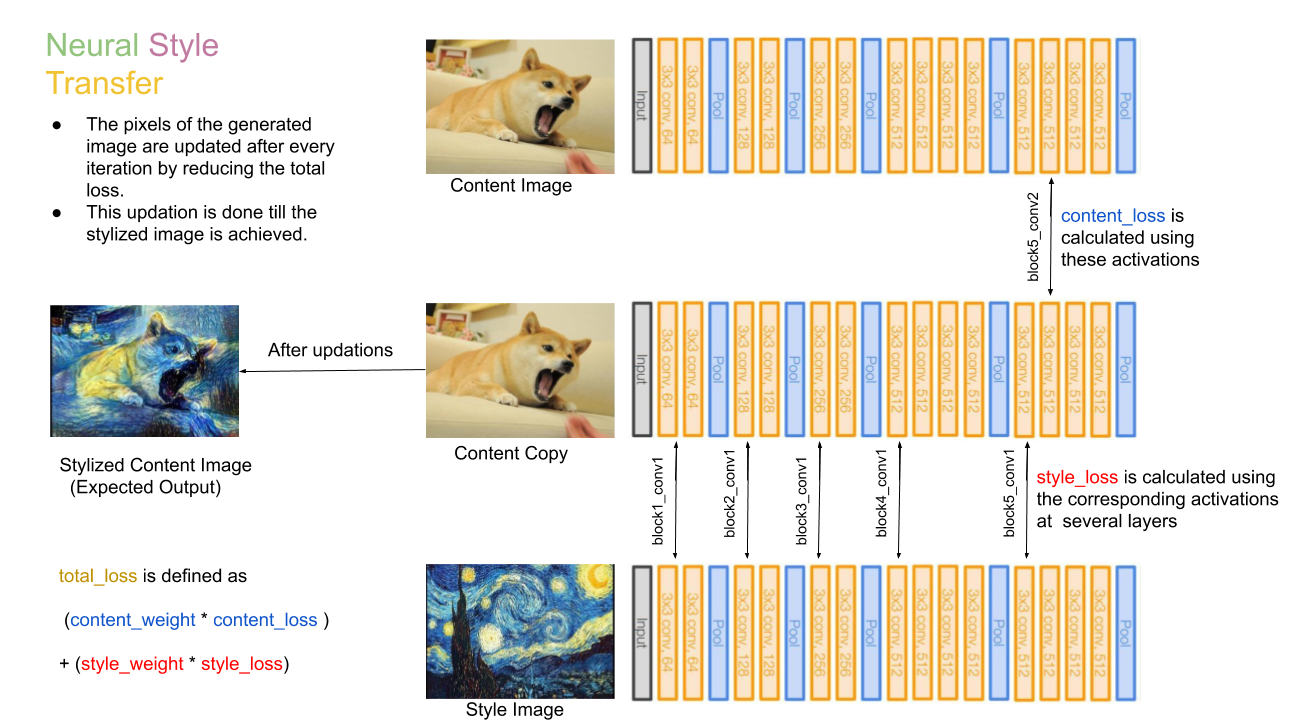enter image description here

We follow the below steps to define the content and style representations:

* Using the pre-trained VGG19 weights, we shall input the content image to the network, to get the target content representations from the content image.
* Similarly, we shall input the style image to the network, to get the target gram matrices(we would discuss gram matrices later) which represent the style from the style image.
* Having gotten the target content and style representations, we shall now pass the copy of the content image(let us call it the generated image) to get it's content and style representations.
* We shall then calculate the distance of the target content and style representations from those of the generated image, to calculate the corresponding content and style errors.
* We shall then define the total loss, having the content, and style losses as its components.
* We shall use gradient descent to update the image pixels of the generated image, such that the total loss is minimized.

Thus, for an input image, we try to match the corresponding style and content target representations at the corresponding intermediate layers.

## Importing Modules
Let us begin by importing the necessary modules. We shall implement the project using Tensorflow 2.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import IPython.display as display
import numpy as np
import PIL.Image
import time
import matplotlib.pyplot as plt

## Load the Images
Let us first load and visualize the content and style images we want to work with.

We shall do that by:

* defining the function load_img to load an image and limit its maximum dimension to 512 pixels.

* creating a simple function imshow to display an image

We shall create the function load_img in this slide, and create the imshow function in the next slide.

**Note:**

* tf.io.read_file(path_to_img) reads the entire contents of the input filename.

It returns a Tensor of type string which contains bit-representations of the image.

* tf.image.decode_image(img, channels=3) detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type uint8. For uint8, the minimum value is 0 and the maximum value is 255.

Images that are represented using floating-point values are expected to have values in the range [0,1).

Image data stored in integer data types are expected to have values in the range [0,MAX], where MAX is the largest positive representable number for the data type.

This op converts between data types, scaling the values appropriately before casting.

* tf.image.convert_image_dtype(img, tf.float32) converts the image tensor values to the specified dtype, scaling its values if needed.

* tf.shape(input_tensor) returns the shape of a tensor.

* tf.cast casts a tensor to a new type.

* tf.cast(tf.shape(img)[:-1], tf.float32) converts all the dimensions - except the last dimension - of the img to float32 data type.

* tf.image.resize resizes image to a specified size.

* tf.newaxis is used to increase the dimension of the existing array by one more dimension.

In [3]:
content_path = "/cxldata/dlcourse/dog.jpg"
style_path = "/cxldata/dlcourse/moon.jpg"


We shall now define the function load_img as follows:

* Set max_dim to 512 to set the maximum dimensions of the input image.

* Read the image from the given path using tf.image.decode_image.

* Convert the image pixels to float32 using tf.image.convert_image_dtype.

* Get the maximum dimension long_dim from the shape of the input image. The max_dim is divided by this long_dim to get the scale measure so that the scale could be used to resize the image.

* The shape is multiplied by scale and the integer result is used along with tf.image.resize to resize the image.

The above steps are Pythonically implemented as follows. So use the below code to load the image.

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [5]:
content_image  = load_img(content_path)
style_image = load_img(style_path)

## Visualize the Images
We shall visualize the images that we have loaded previously. We shall define the imshow function to do the same.

**Note:**

tf.squeeze removes dimensions of size 1 from the shape of a tensor.

We shall define the imshow function. We shall pass the image and the title as input arguments to the function.

* We shall squeeze the fourth dimension, if any.
* We shall also display the title of the image, if any.

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

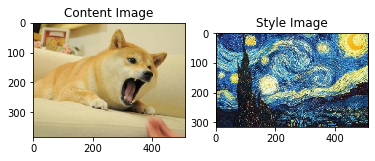

In [7]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [8]:
print("Content image shape: ", content_image.shape)
print("Style image shape: ", style_image.shape)

Content image shape:  (1, 384, 512, 3)
Style image shape:  (1, 315, 512, 3)


## Loading Pre-trained VGG19
Let us load VGG19 previously trained to classify Imaagenet data. Let us test run it on our image to ensure it's used correctly.

**Note:**

* tf.keras.applications are canned architectures with pre-trained weights.

* tf.keras.applications.VGG19 is VGG19 model for Keras.

* tf.keras.applications.vgg19.preprocess_input returns the images converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

* tf.image.resize resizes image to size using the specified method.

* tf.keras.applications.vgg19.decode_predictions decodes the prediction of an ImageNet model.

* vgg.layers returns the list of all the layers in the vgg model.

In [9]:
#Get the preprocessed form of the content_image using tf.keras.applications.vgg19.preprocess_input.
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)

We will have to set include_top=True since we want to cross-check if the network is able to correctly predict our content_image. When setting include_top=True and loading imagenet weights, input_shape should be (224, 224, 3). So, let us resize it using tf.image.resize.

In [10]:
x = tf.image.resize(x, (224, 224))

In [11]:
#Now, let us instantiate the VGG19 model as follows, using tf.keras.applications.VGG19:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

#Pass x, that is the preprocessed and resized content image, to the vgg and get the prediction_probabilities. We expect the shape of this prediction_probabilities to be of 1000 dimensions, as VGG19 on the Imagenet database is trained to classify 1000 classes.

In [12]:
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

(1, 1000)


In [13]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions( prediction_probabilities.numpy() )[0]

print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])

[('dingo', 0.20264639), ('Pembroke', 0.17174084), ('basenji', 0.114593424), ('Labrador_retriever', 0.047086824), ('chow', 0.03621422)]


Observe that the classes predicted are all different breeds of dogs (you could google these classes to cross-check though :-D ).

This assures that the network is able to recognize that it is an image of a dog! Voila, the network is already powerful enough to recognize the main features of the given image! So we can assuredly go forward to use this to extract the features (content from content image and style from the style image) of the input image!

Now, let us load the VGG19 network without the classification head (by setting include_top to False) , just to see the list of all the layer names.

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
#Now, let us choose intermediate layers from the network to represent the style and content of the image:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        'block4_conv1', 
        'block5_conv1']

## Getting model with the specified VGG19 Layers
We have defined from which layers we are going to extract the content of the image, and from which layers we are going to extract the style of the image. We shall define a function vgg_layers to do the same.

We will be getting an instance VGG19, and we will be getting the weights of these layers so that these weights act as the feature extractors and these features will be used by use as discussed previously.

Note:

* Say vgg is an instance of tf.keras.applications.VGG19. Then, vgg.get_layers(layer_name).output returns the weights of the given layer. layer_name is the layer name in string format.

* tf.keras.Model takes the input layer and list of other layers( regarded as output layers) as input arguments, and returns the model with these layers.

Define the vgg_layers function and pass the layers as input argument. In this function, we will:

* get the instance vgg of tf.keras.applications.VGG19(include_top=False, weights='imagenet'). Remember, we have to set include_top=False, as this is not a classification problem, but we just want to use the network as a feature extractor to extract the content and the style.

* set the trainable to False since we are not training the network but we will be using the same pre-trained.

* use vgg.get_layer(name).output to get weights of that layer.

* finally, we will return the model with the specified layer weights.

All the above steps are Pythonically implemented in the below function. Use the below code to do the same.

In [16]:
def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [17]:
#Now, call the vgg_layer function and pass the style_layers as the input argument to the function to get the style extractor model.
style_extractor = vgg_layers(style_layers)

In [18]:
#Now, pass the style_image*255 to this style_extractor. This returns the layer-wise names and outputs.
style_outputs = style_outputs = style_extractor(style_image*255)

In [19]:
#Let us look at the statistics of each layer's output:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 315, 512, 64)
  min:  0.0
  max:  804.6958
  mean:  29.622654

block2_conv1
  shape:  (1, 157, 256, 128)
  min:  0.0
  max:  3484.2507
  mean:  185.36594

block3_conv1
  shape:  (1, 78, 128, 256)
  min:  0.0
  max:  6815.1836
  mean:  172.339

block4_conv1
  shape:  (1, 39, 64, 512)
  min:  0.0
  max:  16559.87
  mean:  639.3219

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  2767.9988
  mean:  50.856007



## Calculating Style
The content of an image is represented by the values of the intermediate feature maps.

On the other hand, the style of an image can be described by the means and correlations across the different feature maps. We calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

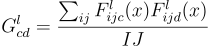



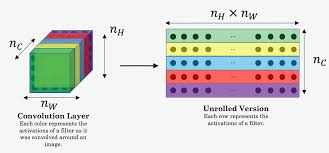

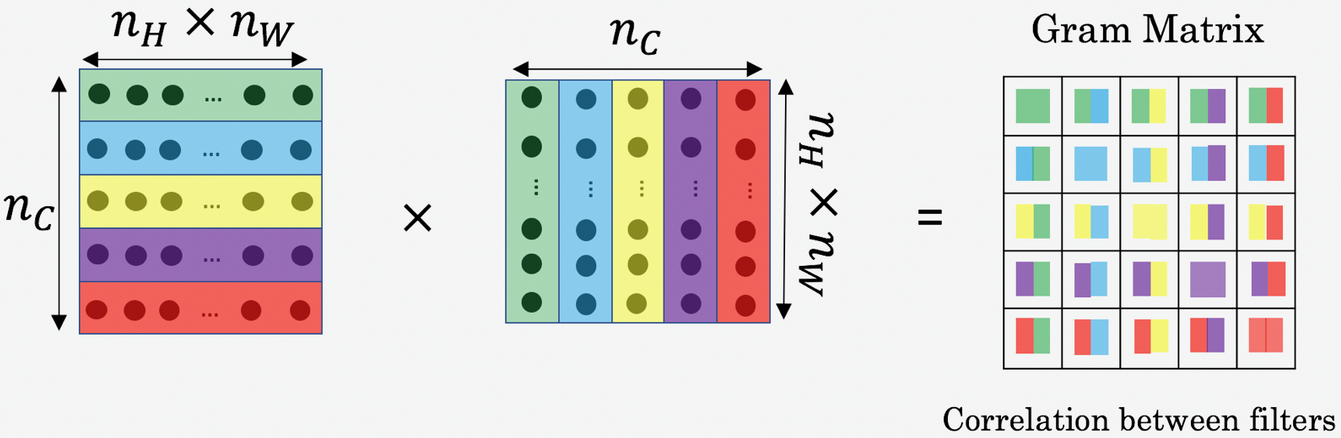

This can be implemented concisely using the tf.linalg.einsum function:

We shall now define a function to calculate the gram matrix, given the style activations from a layer.

Define the function gram_matrix and pass the input_tensor, which would potentially be the output activations from an intermediate style layer of the input image. We shall implement the following steps in the function:

Calculate the numerator of the above-mentioned gram matrix formula.

Divide the thus obtained result with the multiplication of the width and height of the image.

Use the below code to calculate the gram matrix of given input tensor:

In [20]:
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

## Extracting style and content - 1
We are going to define a class to extract the style and content of a given image.

* So basically, we build a model that returns the style and content tensors.

* Inside of Keras the Model class is the root class used to define a model architecture. Since Keras utilizes object-oriented programming, we can actually subclass the Model class and then insert our architecture definition.

* Model subclassing is fully-customizable and enables you to implement your own custom forward-pass of the model.

* We are going to define our custom style-content extractor for the given image by subclassing tf.keras.models.Model. We do that by:

Define __init()__:

    * Call the super().__init__(), the constructor of tf.keras.models.Model which is the parent class.
    * Next, we shall set self.vgg to the vgg_layers function which we have previously defined. This returns the custom model with the specified style layers and content layers.
    * Define the layers for content and style extraction in our custom model.
    * It is important to set the trainable to False, as we want to use the same VGG19 weights trained on ImageNet Database.
Define call method:

call method is regarded as the forward pass of the model. We would customize it.

In our scenario, we define call such that we will be returned the gram-matrices representing the style of the image and, the content of the image will be returned. We shall implement the following steps in the call function:

    * We would first scale the input image values to the range [0,255].
    * Then, we shall preprocess the image using tf.keras.applications.vgg19.preprocess_input.
    * Next, we shall pass this preprocessed input to our custom model - self.vgg - we defined with the specified style and content layers using vgg_layers funtion. This returns the outputs, which contains the style and content matrices for our input image.
    * Now that we have got the style representation matrices, we shall proceed to calculate the gram-matrices of each of the style layers. We shall call gram_matrix function to do this.
    * Finally, we shall return a dictionary holding the content representations and the layer-wise gram-matrices for style representations of the given input image.
Note:

super().__init__() calls our parent constructor. From there on, our layers are defined as instance attributes. Attributes in Python use the self keyword and are typically (but not always) defined in a constructor.

tf.keras.applications.vgg19.preprocess_input returns preprocessed NumPy array or a tf.Tensor with type float32. The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

call : Once the layers of our choice are defined, we can then define the network topology/graph inside the call function which is used to perform a forward-pass.

In [21]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                              outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)  
                            for style_output in style_outputs]
        content_dict = {content_name:value 
            for content_name, value 
            in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
          for style_name, value
          in zip(self.style_layers, style_outputs)}    
        return {'content':content_dict, 'style':style_dict}

## Extracting style and content - 2
We shall now use the class StyleContentModel defined in the previous slide.

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

Note:

    * tf.constant() creates a constant tensor from a tensor-like object.

    * The output returned by the result items are of type tensorflow.python.framework.ops.EagerTensor. So we shall convert that into NumPy array and find the mathematical statistics - like minimum value, mean value, etc - of each output.

In [22]:
extractor = StyleContentModel(style_layers, content_layers)


In [23]:
results = extractor(tf.constant(content_image))


In [24]:
for name, output in sorted(results['style'].items()):
      print("  ", name)
      print("    shape: ", output.numpy().shape)
      print("    min: ", output.numpy().min())
      print("    max: ", output.numpy().max())
      print("    mean: ", output.numpy().mean())
      print()

   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0009752749
    max:  38465.152
    mean:  223.63495

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  41885.992
    mean:  5817.8

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  177181.86
    mean:  5327.621

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1249220.6
    mean:  90560.234

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  37045.61
    mean:  915.18506



In [25]:
for name, output in sorted(results['content'].items()):
       print("  ", name)
       print("    shape: ", output.numpy().shape)
       print("    min: ", output.numpy().min())
       print("    max: ", output.numpy().max())
       print("    mean: ", output.numpy().mean())

   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1372.2462
    mean:  11.231072


## Getting the Target Content and Style
With StyleContentModel which is a style and content extractor, we can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Let us set the style and content target values. We shall do this by extracting the style of the style image and content of the content image.

In [26]:
content_targets = extractor(content_image)['content']

In [27]:
style_targets =extractor(style_image)['style']

## Defining some Hyper-parameters
Let us define the following hyper-parameters we would be using:

style_weight

content_weight

an optimizer, here we shall use Adam and set its hyper-parameters values like the learning rate.

We shall also create a function clip_0_1 that would clip the values of image pixels to be in between 0 and 1 since this is a float image.

We shall also define the variable image which we would be using further to update its pixels throughout the train-steps in the coming slides. We shall assign the tf.Variable(content_image) to the image. We use tf.Variable since the pixel values of this image are to be updated through the gradient descent.

**Note:**

tf.clip_by_value clips tensor values to a specified min and max.

In [28]:
style_weight=1e-2
content_weight=1e4

In [29]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [30]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [31]:
image = tf.Variable(content_image)

## Defining Loss Function
Let us now define the style loss and content loss for the input image. We would be using the style_targets and content_targets to do this.

To do this, we shall define a function style_content_loss and implement the following steps:

* Store the content representation and gram matrices of the style representations of the input image.
* Calculate the mean squared difference between the gram matrices of the respective layers of the input image from the target representations. Add these average squared distances and scale this loss with style_weight to obtain the style_loss.
* Calculate the squared difference between the content representations of the input image from the target representations. Add these average squared distances and scale this loss with content_weight to obtain the content_loss.
* Add the style_loss and content_loss to obtain the total loss loss.

**Note:**

* tf.reduce_mean computes the mean of elements across dimensions of a tensor.

* tf.add_n adds all input tensors element-wise.

In [38]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(
                                (style_outputs[name] - style_targets[name])**2) 
                                for name in style_outputs.keys()] )
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean(
                                (content_outputs[name]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Converting Tensor to Image
Let us define a function tensor_to_image to convert the input tensor to an image format.

We do that as follows:

* Make the pixel values from [0 , 1] to [0, 255].

* Convert the pixels from float type to int type.

* Get the first item(the image with 3 channels) if the tensor shape is greater than 3. In our exercise, the input tensor will be 4, where the first dimension is always 1. It is so because some of the functions we are using will be expecting the input tensors to be of size 4, for processing purposes.

* Use PIL.Image.fromarray(tensor) to convert the tensor to image.

In [42]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## Define the Training Step
Now it's the time to define the training step. We shall use tf.GradientTape to update the image.

Let us define train_step(image) function which performs the calculation of gradient and updation of image pixel values for each train step epoch.

In defining the train_step function, the following steps are implemented:

* Calculate the outputs which are the style and content representations of the input image, using the extractor which is the object of StyleContentModel. Then, call the function style_content_loss function to get the weighted-loss of the input image. Record all these operations using tf.GradientTape().

* Based on the thus obtained loss, calculate the gradients, using tape.gradient(loss, image).

* Then, apply these gradients using opt.apply_gradients.

* Finally, update the image as per the gradients and clip the pixel values to be in 0-1 range.

Note:

* @tf.function converts a Python function to its graph representation for Faster execution, especially if the function consists of many small ops. The pattern to follow is to define the training step function, that's the most computationally intensive function, and decorate it with @tf.function.

* tf.GradientTape() records the list of the operations, so that these could be used for automatic differentiation during optimization. It is very highly recommended to go through the official docs in order to gain a bigger picture of this.

* optimizer.apply_gradients applies the gradients.

In [45]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

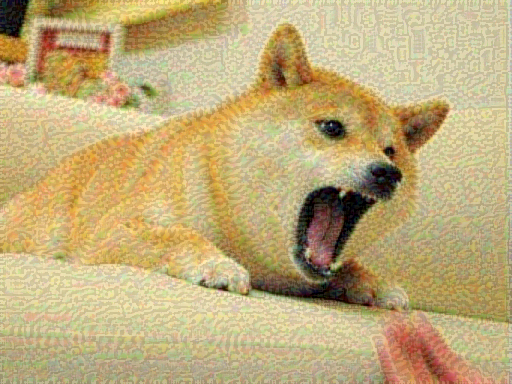

In [46]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

## Optimization
Since it's working, perform a longer optimization.

We shall implement the optimization as follows:

* Let us go perform 5 epochs, each having 10 steps.

* In each step, we will be calling the train_step function which implements the actual optimization of the image pixels by calling various fore-defined functions for each iteration.

* For each epoch, let us display the image with the updated pixels.

* Let us also calculate the amount of time taken to perform this optimization. Let us use the time module.

Note:

* time.time() method returns the time as a floating-point number expressed in seconds since the epoch, in UTC.

    We shall store the starting time in using time.time() in the beginning of the optimization code, and end=time.time(). Then, end-start gives the elapsed seconds taken to perform the optimization.

* We imported IPython.display as display in the beginning of the exercise. Now,

    * display.clear_output() clears the output of the current cell receiving the output. It has a boolean parameter wait. If it is turned True, it means to wait to clear the output until the new output is available to replace it.

    * display.display() displays a Python object in all frontends.

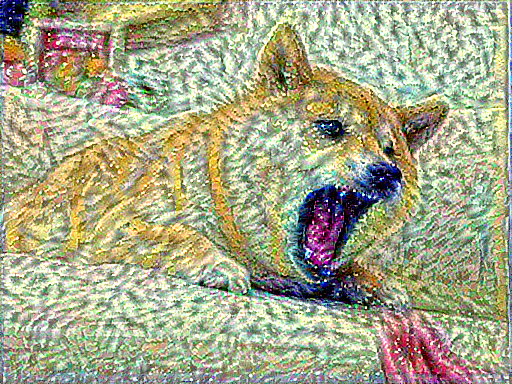

Train step: 50
Total time: 74.4


In [49]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Due to the time and resource constraints, we have selected the specified number of epochs and steps.

Let us view the output image after training for 1000 iterations. Use the code below for the same:

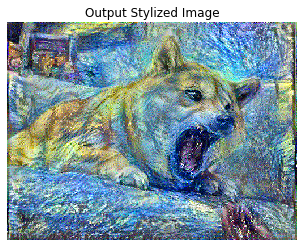

In [50]:
stylized_image = load_img("/cxldata/dlcourse/output-stylized-image.png")
plt.figure(figsize=(6,4))
plt.axis('off')
imshow(stylized_image, 'Output Stylized Image')

We could observe the style of the painting to be imparted into the content image, thus making us feel as if the dog image was drawn using the style of the style image.